## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [2]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [3]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)
    
print(metadata.head())

  subject    age   sex
0   e198a  20-24  Male
1   e198b  20-24  Male
2   e028b  30-34  Male
3   e028a  30-34  Male
4   e061b  30-34  Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [4]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = os.path.splitext(os.path.basename(filename))[0]

    # Find the age group for this subject in metadata.
    age_group = metadata.loc[metadata['subject'] == subject, 'age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata.loc[metadata['subject'] == subject, 'sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

print(df.head())

  age_group     sex        rhr
0     60-64  Female  89.302326
1     65-69    Male  65.641026
2     45-49    Male  56.928458
3     60-64    Male  68.571429
4     50-54    Male  84.395604


In [5]:
df['age_group'].value_counts()

60-64    313
65-69    291
55-59    261
70-74    196
50-54    164
45-49    124
75-79     98
40-44     62
35-39     28
Name: age_group, dtype: int64

In [6]:
df['sex'].value_counts()

Male      1260
Female     277
Name: sex, dtype: int64

#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

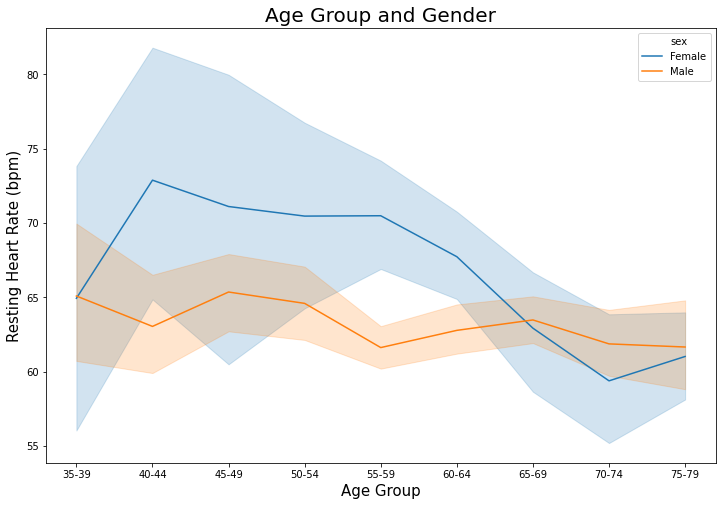

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

plt.title('Age Group and Gender', size = 20)
plt.xlabel('Age Group', size = 15) 
plt.ylabel('Resting Heart Rate (bpm)', size = 15) 
plt.show()

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see .... 
> 2. For men, we see ... 
> 3. In comparison to men, women's heart rate is .... 
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

Your write-up will go here...

1. For women, we see an increase in the resting heart rate (RHR) that reaches a peak at the 40-44 age range. From that age, the RHR decreases for women. The 95% confidence interval around the RHR mean is higher near to the peak, meaning there is more variance in the data around this age.

2. For men, there is more fluctuation in the RHR along the age groups but with a more stable 95% confidence interval. It may be noticed a peak around the 45-49 age range but it is not as sharp as the peak for females.

3. In comparison to men, women's RHR is higher. It is also higher the 95% confidence interval around its mean, mainly around the peak at 40-44. Females with ages in the 40-44 group had the highest average RHR of all patients. The RHR mean reaches its peak for females and males at around 73 bpm (40-44 age) and 65 bpm (45-49 age) respectively.

4. In our data, we can see the role of biological gender in the RHR, which in average is higher for females than for males. This difference is largely accounted for by the size of the heart, which is typically smaller in females than males. The smaller female heart, pumping less blood with each beat, needs to beat at a faster rate. Further women have a different intrinsic rhythmicity to the pacemaker of their hearts, which causes them to beat faster [1]. Besides, we can also see the effect of age. With increasing age, a decrease of the maximal heart rate achieved is observed in subjects free of heart disease [2].

5. We observe a very high 95% confidence interval around the RHR mean for females, mainly in the younger ages. If we look at the data, we have 277 females and 1260 males. Also, we have less data for young ages. Therefore, results could be improved by taking more female subjects at ages below 55. Besides, the dataset that we used had only 36000 hours. We could improve results by using more hours. This is shown in [3], where they used the same analysis than in this project but using 100+ billions of hours instead.

6. The trend that average resting heart rate increases up until middle age and then decreases into old age is validated in the case of females by looking at the RHR mean. However, for males we would need more data for young ages (35-50) to be able to observe the peak.



[1] K. Prabhavathi, K.Tamarai Selvi, K.N. Poornima, and A. Sarvanan. Role of Biological Sex in Normal Cardiac Function and in its Disease Outcome – A Review. J Clin Diagn Res. 2014. DOI: 10.7860/JCDR/2014/9635.4771

[2] J.B. Kostis, A.E. Moreyra, M.T. Amendo, J. Di Pietro, N. Cosgrove, and P.T. Kuo. The effect of age on heart rate in subjects free of heart disease. Studies by ambulatory electrocardiography and maximal exercise stress test. Circulation. 1982. DOI: 10.1161/01.cir.65.1.141

[3] Press Release (2018): Fitbit’s 100+ Billion Hours of Resting Heart Rate User Data Reveals Resting Heart Rate Decreases After Age 40. https://www.businesswire.com/news/home/20180214005548/en/